In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd

caminho_do_arquivo = '/content/drive/MyDrive/participantData.csv'

df = pd.read_csv(caminho_do_arquivo, sep = ";")
columns = [f'character_{i}' for i in range(1, 13)]  # Ajuste conforme as colunas reais

# Substitui NaN por 'empty' e mapear os valores para inteiros
df[columns] = df[columns].fillna('empty')
print(df.head(10))

# Criar o mapeamento de valores únicos para inteiros, incluindo o mapeamento de NaN para empty
unique_values = pd.unique(df[columns].values.ravel())
mapping_dict = {value: idx for idx, value in enumerate(unique_values) if value != 'empty'}
mapping_dict['empty'] = 68

# Substituir os valores no DataFrame usando o mapeamento e ordenando
df[columns] = df[columns].replace(mapping_dict)
df[columns] = df[columns].apply(lambda row: sorted(row), axis=1, result_type='expand')

# Normalizar os valores na coluna
min_val = min(mapping_dict.values())
max_val = max(mapping_dict.values())
normalized_df = df[columns].apply(lambda row: [(val - min_val) / (max_val - min_val) for val in row])

# Substituir os valores normalizados de volta no DataFrame
df[columns] = normalized_df
df.drop_duplicates(inplace=True)  # Remover linhas duplicadas caso existam

# Exibir o DataFrame resultante
print("DataFrame após normalização:")
print(df.head(10))

# Exibir o dicionário de mapeamento normalizado
normalized_mapping_dict = {key: (value - min_val) / (max_val - min_val) for key, value in mapping_dict.items()}
print("\nDicionário de mapeamento normalizado:")
print(normalized_mapping_dict)

      character_1     character_2       character_3        character_4  \
0      TFT13_Blue    TFT13_Irelia        TFT13_Sett      TFT13_Camille   
1     TFT13_Amumu  TFT13_Nocturne       TFT13_Akali   TFT13_Blitzcrank   
2    TFT13_Irelia     TFT13_Akali        TFT13_Sett        tft13_elise   
3    TFT13_Singed    TFT13_Irelia        TFT13_Rell  TFT13_RenataGlasc   
4   TFT13_Morgana  TFT13_Vladimir  TFT13_Cassiopeia        tft13_elise   
5   TFT13_Morgana  TFT13_Vladimir  TFT13_Blitzcrank   TFT13_Cassiopeia   
6   TFT13_Morgana  TFT13_Vladimir  TFT13_Blitzcrank   TFT13_Cassiopeia   
7      TFT13_Rell  TFT13_Tristana        TFT13_Nami      TFT13_Ambessa   
8    TFT13_Darius    TFT13_Draven        TFT13_Blue          TFT13_Red   
9  TFT13_Vladimir  TFT13_Tristana        TFT13_Nami      TFT13_Ambessa   

          character_5      character_6        character_7        character_8  \
0        TFT13_Ezreal    TFT13_Gremlin         TFT13_Ekko       TFT13_Illaoi   
1    TFT13_Blitzcrank    

<ipython-input-14-98deadfb1fa5>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns] = df[columns].replace(mapping_dict)


DataFrame após normalização:
   character_1  character_2  character_3  character_4  character_5  \
0     0.000000     0.014706     0.029412     0.044118     0.058824   
1     0.161765     0.176471     0.191176     0.205882     0.205882   
2     0.014706     0.029412     0.102941     0.117647     0.132353   
3     0.014706     0.102941     0.323529     0.338235     0.352941   
4     0.264706     0.294118     0.411765     0.426471     0.441176   
5     0.205882     0.264706     0.411765     0.426471     0.441176   
6     0.205882     0.264706     0.264706     0.411765     0.426471   
7     0.250000     0.338235     0.382353     0.544118     0.558824   
8     0.000000     0.279412     0.308824     0.500000     0.514706   
9     0.250000     0.426471     0.514706     0.544118     0.558824   

   character_6  character_7  character_8  character_9  character_10  \
0     0.073529     0.088235     0.102941     0.117647      0.132353   
1     0.220588     0.235294     0.250000     1.000000     

<ipython-input-28-b61736f59119>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['placement_mean'] = df['placement_mean']


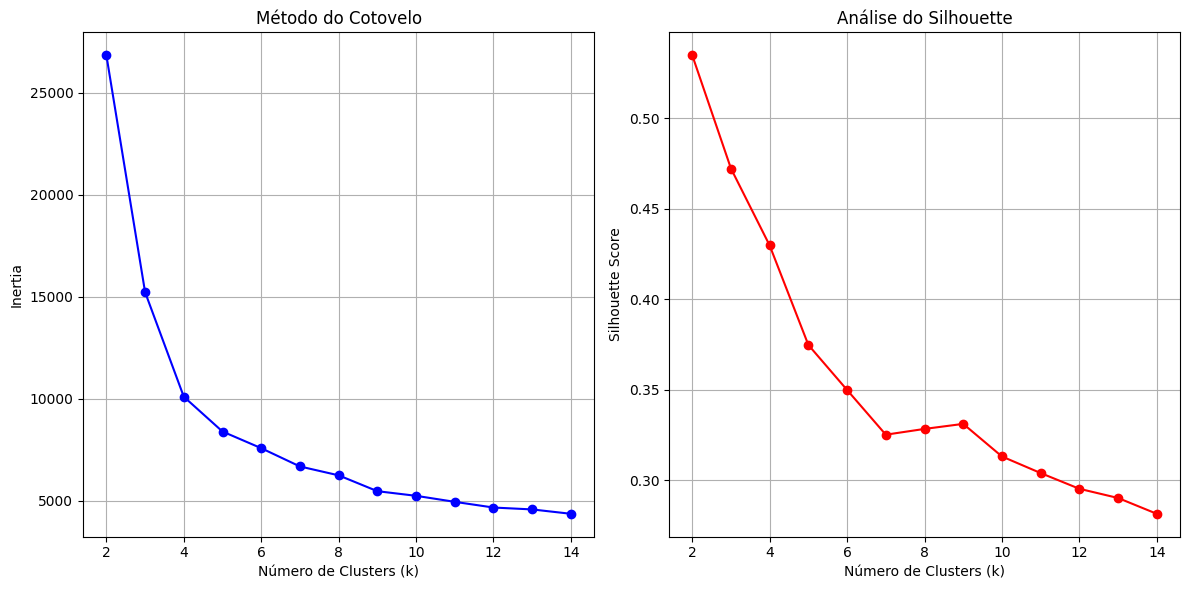

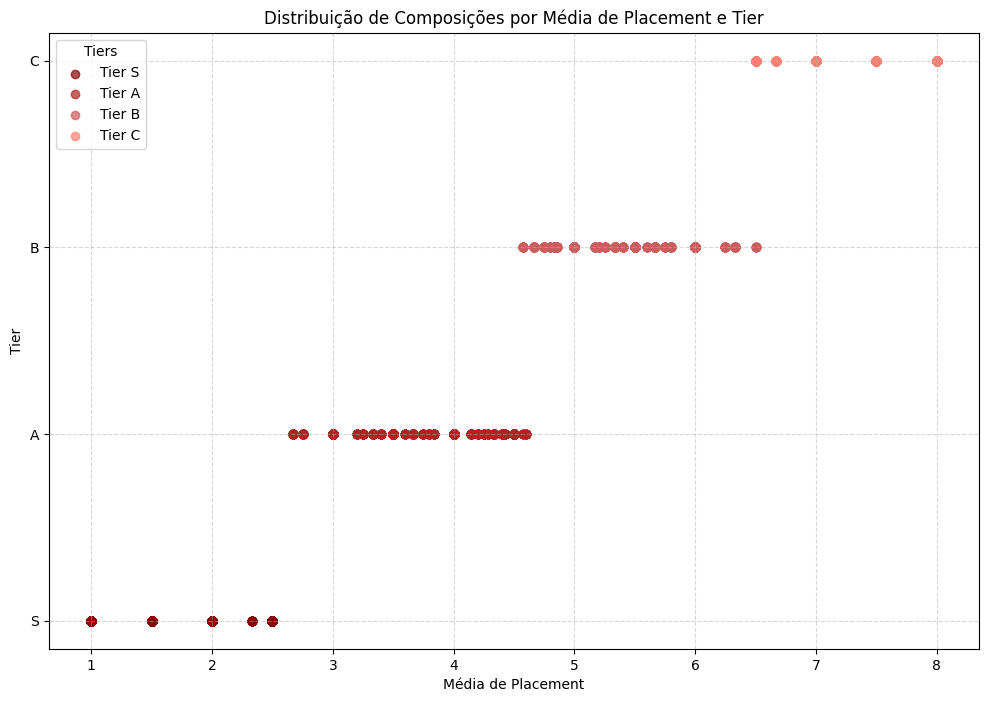

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Colunas character_1 até character_12 formam a composição
character_columns = [f'character_{i}' for i in range(1, 13)]
X = df[character_columns]

# Coluna 'composition' representa a combinação única das 12 colunas
df['composition'] = df[character_columns].apply(lambda row: '-'.join(row.astype(str)), axis=1)

# Calcular a média de placement para cada composição
composition_mean_placement = df.groupby('composition')['placement'].mean()
df['placement_mean'] = df['composition'].map(composition_mean_placement)

# Adiciona a coluna 'placement' como uma feature adicional ao KMeans
X['placement_mean'] = df['placement_mean']

# Método do Cotovelo para determinar o número ideal de clusters
inertia = []
silhouette_scores = []
K = range(2, 15)  # Testar de 2 a 14 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 6))

# Inertia Plot (Método do Cotovelo)
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-', label='Inertia')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inertia')
plt.title('Método do Cotovelo')
plt.grid(True)

# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-', label='Silhouette Score')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Análise do Silhouette')
plt.grid(True)

plt.tight_layout()
plt.show()

# Aplicar o KMeans com 4 clusters (Tiers S até H)
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Mapear os clusters para os tiers (S, A, B, C)
cluster_order = df.groupby('cluster')['placement'].mean().sort_values().index
tier_mapping = {cluster: tier for cluster, tier in zip(cluster_order, ['S', 'A', 'B', 'C'])}
df['tier'] = df['cluster'].map(tier_mapping)

tier_colors = {
    'S': '#8B0000',
    'A': '#B22222',
    'B': '#CD5C5C',
    'C': '#FA8072'
}

# Criar o gráfico de dispersão com cores baseadas nos tiers
plt.figure(figsize=(12, 8))

# Mapear tiers para cores e plotar os pontos
for tier, color in tier_colors.items():
    tier_data = df[df['tier'] == tier]
    plt.scatter(tier_data['placement_mean'], [tier] * len(tier_data),
                color=color, label=f'Tier {tier}', alpha=0.7)

# Configurações do gráfico
plt.xlabel('Média de Placement')
plt.ylabel('Tier')
plt.title('Distribuição de Composições por Média de Placement e Tier')
plt.yticks(['S', 'A', 'B', 'C'])  # Ordem dos tiers no eixo Y
plt.legend(title="Tiers")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [31]:
# Cria um dicionário inverso para mapear valores normalizados de volta para strings
inverse_mapping_dict = {v: k for k, v in normalized_mapping_dict.items()}

# Substitui os valores normalizados por strings originais nas colunas character_1 até character_12
df_string = df[character_columns].applymap(lambda val: inverse_mapping_dict.get(val, 'N/A'))

# Coluna 'composition_str' concatenando as strings das colunas
df['composition_str'] = df_string.apply(lambda row: '-'.join(row.astype(str)), axis=1)

print("\nComposições por Tier:")

# Agrupar por tier e listar as composições
for tier in sorted(df['tier'].unique()):
    print(f"\nTier {tier}:")
    tier_data = df[df['tier'] == tier]

    compositions = tier_data['composition_str'].head(5)  # 5 primeiras

    for id, comp in compositions.items():
        print(f"Identificador: {id} | Composição: {comp}")

<ipython-input-31-e7ebe0d719e2>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_string = df[character_columns].applymap(lambda val: inverse_mapping_dict.get(val, 'N/A'))



Composições por Tier:

Tier A:
Identificador: 2 | Composição: TFT13_Irelia-TFT13_Sett-TFT13_Illaoi-TFT13_Zoe-tft13_jinx-TFT13_Akali-tft13_elise-TFT13_Jayce-TFT13_LeBlanc-TFT13_JayceSummon-empty-empty
Identificador: 3 | Composição: TFT13_Irelia-TFT13_Illaoi-TFT13_Singed-TFT13_Rell-TFT13_RenataGlasc-TFT13_Heimerdinger-TFT13_Malzahar-TFT13_Warwick-empty-empty-empty-empty
Identificador: 8 | Composição: TFT13_Blue-TFT13_Jayce-TFT13_JayceSummon-TFT13_Lieutenant-TFT13_Viktor-TFT13_Darius-TFT13_Draven-TFT13_Red-TFT13_Prime-TFT13_Gangplank-empty-empty
Identificador: 10 | Composição: TFT13_Irelia-TFT13_Ezreal-TFT13_Illaoi-TFT13_Jayce-TFT13_JayceSummon-TFT13_Rell-TFT13_Heimerdinger-TFT13_Corki-TFT13_Rumble-TFT13_Leona-empty-empty
Identificador: 16 | Composição: TFT13_Amumu-TFT13_Nocturne-TFT13_Akali-TFT13_Blitzcrank-TFT13_KogMaw-TFT13_TwistedFate-TFT13_Ambessa-TFT13_Mordekaiser-empty-empty-empty-empty

Tier B:
Identificador: 1 | Composição: TFT13_Amumu-TFT13_Nocturne-TFT13_Akali-TFT13_Blitzcrank